# **Deep Space Neural Cryptography**
---
**Course**: 4NN3 - McMaster University

The project aims to enhance deep space communication security and tackle the challenges posed by quantum computing to traditional cryptographic methods. Using a Generative Adversarial Network (GAN), the project develops a novel encryption and decryption algorithm that adapts and strengthens in the presence of an adversary.

The design of the neural network model is shared between the ground station and spacecraft, using 16-bit message and key lengths as input. The network architecture differs for the ground station (encrypting plaintext) and the spacecraft (decrypting ciphertext), with the adversary's model being more complex to decrypt without a key.

The encryption model's loss function is penalized as the adversary successfully decrypts ciphertext, simulating a real-world known plaintext attack.

Training involves multiple steps where the ground station encrypts plaintext, the adversary tries to decrypt the ciphertext, and the spacecraft attempts decryption with the key. The training's effectiveness is measured by the adversary's average loss reaching around 50%, indicating a strong encryption level. The spacecraft's average loss reached around 0%, indicating successful decryption using the shared secret key.

The project demonstrates the potential of using neural networks for secure encryption against quantum computing threats, although it requires further research, validation and security analysis.



## **Import Libraries**

In [ ]:
!pip install essential_generators
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv1D, Concatenate, Reshape, Activation
from keras.initializers import  glorot_uniform
from keras.models import Model
from keras.backend import placeholder
import numpy as np
import math
import pandas as pd
from essential_generators import DocumentGenerator
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives import padding
import timeit
import os


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 15.8 MB/s eta 0:00:00


## **Hyperparameters Initialization**

In [ ]:
epochs = 300
iterations = 150
Learning_Rate = 0.0007
Batch_Size = 2048 #Number of combinations of Messages & Keys per iteration
gen=DocumentGenerator()

## **Dataset Generation**
The GenerateData function creates a dataset of binary messages and keys, each 16 bits long, using numpy's randint function to generate random 0s and 1s, formatted for a specified batch size.

In [ ]:
Message_Length = 16 #Length of Each Message
Key_Length = 16 #Length of Secret Key used for Encryption


#Function definition to generate dataset of messages and keys in binary using Numpy's randint function for [0,2) and return the dataset
def GenerateData(batch_size, message_length, key_length):
    messages = np.random.randint(0, 2, size=(batch_size, message_length)).astype(np.float32)
    keys = np.random.randint(0, 2, size=(batch_size, key_length)).astype(np.float32)
    return messages, keys

## **Neural Network Model Definition**
This defines three neural network models for the ground station, the spacecraft, and an adversary.

Ground Station Model: It concatenates the message and key, processes them through a fully connected layer, and then through four 1-D convolutional layers. The output is reshaped.

Spacecraft Model: This model takes the output of the Ground Station model and the same key, passes them through a similar structure as the Ground Station model (a fully connected layer followed by four 1-D convolutional layers), and produces the final output. This model is designed to decrypt the message received from the Ground Station.

Adversary Model: It is designed to cryptanalyze or decrypt the output from the Ground Station without the key. It includes an additional fully connected layer compared to the other two models, followed by four 1-D convolutional layers, making its architecture more complex to give the adversary a competitive advantage.

Each model's architecture is designed to simulate the encryption and decryption process in a secure communication system, with the adversary model attempting to break the encryption without access to the key.

In [ ]:
# Input Layer Placeholder Definition

Message = Input(shape=(Message_Length,), dtype='float32', name='Message')
Key = Input(shape=(Key_Length,), dtype='float32', name='Key')

#################################################
#   Ground Station's Neural Network Model       #
#################################################

# Structure is FC layer -> Conv Layer (4 1-D convolutions)

# Concatenate Message & Key
GroundStation_Input = Concatenate(axis=1)([Message, Key]) #axis 1 concatenates side by side

# Define a Fully Connected Hidden Layer
GroundStation_Hidden_Layer = Dense(2 * Message_Length, activation='sigmoid', kernel_initializer = 'glorot_uniform', name="groundstation_fully_connected")(GroundStation_Input)

# Reshape to match convolutional layer input shape
GroundStation_Hidden_Layer = Reshape((2 * Message_Length, 1))(GroundStation_Hidden_Layer)

# Convolutional Layers
h0 = Conv1D(filters=2, kernel_size=4, strides=1, activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=None), name='groundstation_h0_conv')(GroundStation_Hidden_Layer) #filter = output channel, kernel size = filter height, input is inferred automatically
h1 = Conv1D(filters=4, kernel_size=2, strides=2, activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=None), name='groundstation_h1_conv')(h0)
h2 = Conv1D(filters=4, kernel_size=4, strides=1, activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=None), name='groundstation_h2_conv')(h1)
h3 = Conv1D(filters=1, kernel_size=4, strides=1, activation='tanh', padding='same', kernel_initializer=glorot_uniform(seed=None), name='groundstation_h3_conv')(h2)

# Squeeze dimensions: eliminate dimensions of size 1 from the shape of a tensor
GroundStation_Output = Reshape((-1,))(h3)

GroundStation_model = Model(inputs=[Message,Key], outputs=GroundStation_Output)

GroundStation_model.summary()

#################################################
#   Spacecraft's Neural Network Model           #
#################################################

# Structure is FC layer -> Conv Layer (4 1-D convolutions)

# Concatenate Ground Station's output & the same Key
Spacecraft_Input = Concatenate(axis=1)([GroundStation_Output, Key])

# Define a Fully Connected Hidden Layer
Spacecraft_Hidden_Layer = Dense(2 * Message_Length, activation='sigmoid', kernel_initializer = 'glorot_uniform', name="spacecraft_fully_connected")(Spacecraft_Input)

# Reshape to match convolutional layer input shape
Spacecraft_Hidden_Layer = Reshape((2 * Message_Length, 1))(Spacecraft_Hidden_Layer)

# Convolutional Layers
h0 = Conv1D(filters=2, kernel_size=4, strides=1, activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=None), name='spacecraft_h0_conv')(Spacecraft_Hidden_Layer) #filter = output channel, kernel size = filter height, input is inferred automatically
h1 = Conv1D(filters=4, kernel_size=2, strides=2, activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=None), name='spacecraft_h1_conv')(h0)
h2 = Conv1D(filters=4, kernel_size=4, strides=1, activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=None), name='spacecraft_h2_conv')(h1)
h3 = Conv1D(filters=1, kernel_size=4, strides=1, activation='tanh', padding='same', kernel_initializer=glorot_uniform(seed=None), name='spacecraft_h3_conv')(h2)

# Squeeze dimensions: eliminate dimensions of size 1 from the shape of a tensor
Spacecraft_Output = Reshape((-1,))(h3)

Spacecraft_model = Model(inputs=[GroundStation_Output,Key], outputs=Spacecraft_Output)
Spacecraft_model.summary()

#################################################
#   Adversary's Neural Network Model            #
#################################################

# Structure is FC layer -> FC layer -> Conv layer (4 1-D convolutions)

# Concatenate Ground Station's output & the same Key
Adversary_Input = GroundStation_Output

# Define two Fully Connected Hidden Layer - to make Adversary's network more complex to give the adversary a better chance to cryptanalyze or decrypt GroundStation_Output
Adversary_Hidden_Layer_1 = Dense(2 * Message_Length, activation='sigmoid', kernel_initializer = 'glorot_uniform', name="adversary_fully_connected_1")(Adversary_Input)

Adversary_Hidden_Layer_2 = Dense(2 * Message_Length, activation='sigmoid', kernel_initializer = 'glorot_uniform', name="adversary_fully_connected_2")(Adversary_Hidden_Layer_1)

# Reshape to match convolutional layer input shape
Adversary_Hidden_Layer_2 = Reshape((2 * Message_Length, 1))(Adversary_Hidden_Layer_2)

# Convolutional Layers
h0 = Conv1D(filters=2, kernel_size=4, strides=1, activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=None), name='adversary_h0_conv')(Adversary_Hidden_Layer_2) #filter = output channel, kernel size = filter height, input is inferred automatically
h1 = Conv1D(filters=4, kernel_size=2, strides=2, activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=None), name='adversary_h1_conv')(h0)
h2 = Conv1D(filters=4, kernel_size=4, strides=1, activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=None), name='adversary_h2_conv')(h1)
h3 = Conv1D(filters=1, kernel_size=4, strides=1, activation='tanh', padding='same', kernel_initializer=glorot_uniform(seed=None), name='adversary_h3_conv')(h2)

# # Squeeze dimensions: eliminate dimensions of size 1 from the shape of a tensor
Adversary_Output = Reshape((-1,))(h3)

# Create the model
Adversary_model = Model(inputs=[GroundStation_Output], outputs=Adversary_Output)
# Print the model summary
Adversary_model.summary()




Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Message (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 Key (InputLayer)            [(None, 16)]                 0         []                            
                                                                                                  
 concatenate_10 (Concatenat  (None, 32)                   0         ['Message[0][0]',             
 e)                                                                  'Key[0][0]']                 
                                                                                                  
 groundstation_fully_connec  (None, 32)                   1056      ['concatenate_10[0][0]'

## **Neural Network Training Functions**

Each model's performance is optimized using the Adam optimizer with a defined learning rate. The training involves a forward pass where the ground station encrypts messages, the spacecraft decrypts them, and the adversary attempts to break the encryption. Loss functions for the spacecraft and adversary are calculated using the mean absolute error between the true and predicted messages. The ground station's loss is penalized based on the adversary's success in decryption. The training loop iterates through epochs and iterations, generating data for each batch and updating the models based on the computed gradients of the loss. After each epoch, the minimum errors for each model are recorded and printed, allowing for tracking the models' performance and the effectiveness of the encryption and decryption processes over time.

In [ ]:
GroundStation_errors, Spacecraft_errors, Adversary_errors = [], [], []

# Error calculations and Loss functions

def loss_spacecraft(y_true, y_pred):
    y_true_float = tf.cast(y_true, tf.float32)  # Ensure y_true is float32
    return tf.reduce_mean(tf.math.abs(y_true_float - y_pred))

def loss_adversary(y_true, y_pred):
    y_true_float = tf.cast(y_true, tf.float32)  # Ensure y_true is float32
    return tf.reduce_mean(tf.math.abs(y_true_float - y_pred))


# Define optimizers for each model
optimizer_groundstation = tf.keras.optimizers.Adam(learning_rate=Learning_Rate)
optimizer_spacecraft = tf.keras.optimizers.Adam(learning_rate=Learning_Rate)
optimizer_adversary = tf.keras.optimizers.Adam(learning_rate=Learning_Rate)

# Custom training step
@tf.function
def train_step(models, messages, keys):
    with tf.GradientTape(persistent=True) as tape:
        # Forward pass
        ground_station_output = models['groundstation']([messages, keys], training=True)
        spacecraft_output = models['spacecraft']([ground_station_output, keys], training=True)
        adversary_output = models['adversary'](ground_station_output, training=True)

        # Loss calculations
        loss_spacecraft_val = loss_spacecraft(messages, spacecraft_output)
        loss_adversary_val = loss_adversary(messages, adversary_output)

        # Penalizing the adversary
        loss_groundstation_val = loss_spacecraft_val + (1 - loss_adversary_val) ** 2

    # Calculating gradients
    gradients_groundstation = tape.gradient(loss_groundstation_val, models['groundstation'].trainable_variables)
    gradients_spacecraft = tape.gradient(loss_spacecraft_val, models['spacecraft'].trainable_variables)
    gradients_adversary = tape.gradient(loss_adversary_val, models['adversary'].trainable_variables)

    # Applying gradients
    optimizer_groundstation.apply_gradients(zip(gradients_groundstation, models['groundstation'].trainable_variables))
    optimizer_spacecraft.apply_gradients(zip(gradients_spacecraft, models['spacecraft'].trainable_variables))
    optimizer_adversary.apply_gradients(zip(gradients_adversary, models['adversary'].trainable_variables))

    return loss_groundstation_val, loss_spacecraft_val, loss_adversary_val

def train():


  for epoch in range(epochs):
    min_groundstation_error, min_spacecraft_error, min_adversary_error = float('inf'), float('inf'), float('inf')

    for iteration in range(iterations):
        messages, keys = GenerateData(Batch_Size, Message_Length, Key_Length)
        loss_groundstation, loss_spacecraft, loss_adversary = train_step(
            {'groundstation': GroundStation_model, 'spacecraft': Spacecraft_model, 'adversary': Adversary_model},
            messages, keys
        )

        min_groundstation_error = min(min_groundstation_error, loss_groundstation.numpy())
        min_spacecraft_error = min(min_spacecraft_error, loss_spacecraft.numpy())
        min_adversary_error = min(min_adversary_error, loss_adversary.numpy())

    GroundStation_errors.append(min_groundstation_error)
    Spacecraft_errors.append(min_spacecraft_error)
    Adversary_errors.append(min_adversary_error)

    print(f'Epoch {epoch+1}/{epochs}, GroundStation Error: {min_groundstation_error}, Spacecraft Error: {min_spacecraft_error}, Adversary Error: {min_adversary_error}')

## **Neural Network Training**
This calls the train function and plots the lowest decryption error for each epoch.

Training the models...
Epoch 1/300, GroundStation Error: 0.7498733997344971, Spacecraft Error: 0.491751104593277, Adversary Error: 0.4916544258594513
Epoch 2/300, GroundStation Error: 0.6690245866775513, Spacecraft Error: 0.38939714431762695, Adversary Error: 0.4679994583129883
Epoch 3/300, GroundStation Error: 0.667460560798645, Spacecraft Error: 0.36159276962280273, Adversary Error: 0.4218336343765259
Epoch 4/300, GroundStation Error: 0.6560166478157043, Spacecraft Error: 0.3276764750480652, Adversary Error: 0.4223994314670563
Epoch 5/300, GroundStation Error: 0.598819375038147, Spacecraft Error: 0.27522262930870056, Adversary Error: 0.4280388057231903
Epoch 6/300, GroundStation Error: 0.542249858379364, Spacecraft Error: 0.20753887295722961, Adversary Error: 0.4180811941623688
Epoch 7/300, GroundStation Error: 0.4534456729888916, Spacecraft Error: 0.11859716475009918, Adversary Error: 0.416789710521698
Epoch 8/300, GroundStation Error: 0.43059635162353516, Spacecraft Error: 0.097672

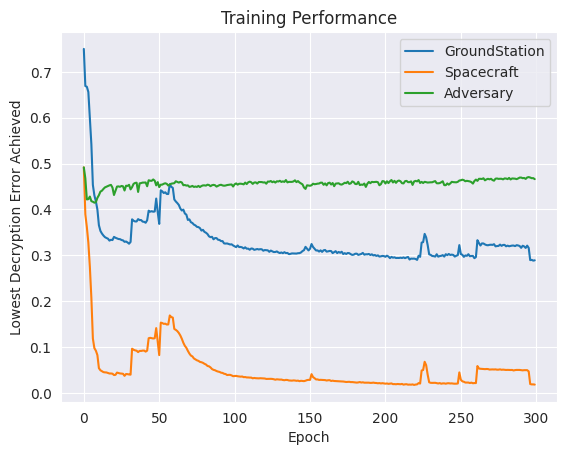

GroundStation_errors_train =  [0.7498734, 0.6690246, 0.66746056, 0.65601665, 0.5988194, 0.54224986, 0.45344567, 0.43059635, 0.4175189, 0.3997305, 0.36555988, 0.35330716, 0.34749943, 0.34313774, 0.33966374, 0.337802, 0.33628574, 0.33204758, 0.33389437, 0.33325064, 0.34016398, 0.338253, 0.33686602, 0.3355269, 0.3352187, 0.33339205, 0.332553, 0.32940862, 0.3301093, 0.32803863, 0.32531175, 0.3291518, 0.37842706, 0.3753531, 0.37384018, 0.37388036, 0.3789261, 0.37681615, 0.3768689, 0.37345624, 0.37298232, 0.3710017, 0.37650853, 0.39733967, 0.3950684, 0.3961593, 0.39505756, 0.3955534, 0.4237271, 0.39428973, 0.36851597, 0.44175243, 0.43946853, 0.43575352, 0.4374227, 0.43371698, 0.4336357, 0.45497608, 0.44931978, 0.44712657, 0.42169243, 0.41732925, 0.41386473, 0.40975767, 0.401923, 0.39767376, 0.3996148, 0.39116183, 0.38862044, 0.37708685, 0.37838703, 0.37218267, 0.37044844, 0.36689, 0.3652426, 0.36211637, 0.36148936, 0.3592838, 0.3539263, 0.35557616, 0.35106507, 0.34924975, 0.34636977, 0.34138

In [ ]:
import time
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def plot_results():
    """
    Plot Lowest Decryption Errors achieved by Spacecraft & Adversory per epoch
    """
    sns.set_style("darkgrid")

    plt.plot(GroundStation_errors, label='GroundStation')
    plt.plot(Spacecraft_errors, label='Spacecraft')
    plt.plot(Adversary_errors, label='Adversary')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Lowest Decryption Error Achieved')
    plt.title('Training Performance')
    plt.show()


print('Training the models...')
start_time = time.time()

train()

end_time = time.time()

print('Time taken for Training (seconds): ', end_time-start_time)

plot_results()

print('GroundStation_errors_train = ', GroundStation_errors)
print('Spacecraft_errors_train = ', Spacecraft_errors)
print('Adversary_errors_train = ', Adversary_errors)

## **Converting Text to Binary with Padding**

The text_to_binary_array function converts a given text string into a binary format, represented as a numpy array. It first transforms each character into its 8-bit binary representation, then pads the resulting binary string to ensure its length is a multiple of a specified message length. Finally, the padded binary string is converted into a numpy array, with each row representing a segment of the original text in binary format, following the defined message length.

In [ ]:
def text_to_binary_array(text, message_length=Message_Length):
    # Convert text to binary string
    bintext = ''.join('{:08b}'.format(ord(c)) for c in text)

    # Calculate padding needed to make length a multiple of message_length
    pad_length = (-len(bintext)) % message_length

    # Apply padding
    bintext_padded = bintext + '0' * pad_length

    # Convert to numpy array
    binary_array = np.array([int(bit) for bit in bintext_padded]).reshape(-1, message_length)

    return binary_array


## **Testing**

This script includes functions for testing and evaluating a neural network-based cryptographic system. The binary_to_text function converts binary data back into text, while plot_test_results visualizes the decryption performance of the spacecraft and adversary models across epochs. The testFunc function tests the models by encrypting a plaintext message, attempting decryption by both the spacecraft and adversary, and calculating their respective average Hamming distances. The trainLoop function automates testing over multiple iterations, generating sentences and aggregating the average decryption errors for further analysis and visualization. Finally, the script conducts a defined number of test iterations, computes the average decryption performance for both the spacecraft and adversary, and prints these results.

Streaming output truncated to the last 5000 lines.

Spacecraft text= This is a test on the deep space neural network cryptography project for the 4NN3 course. 


Spacecraft average Hamming distance =0.0

Adversary average Hamming distance =7.466666666666667
Plain text = plain_text='Dakota in electrons it is thought to be some other countries.'


Binary Plain text = 
[[0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0]
 [0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1]
 [0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1]
 [0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0]
 [0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0]
 [0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 1]
 [0 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1]
 [0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0]
 [0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 0]
 [0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0]
 [0 1 1 0 0 1 0 0 0 1 1 0 0 1 0 1]
 [0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1]
 [0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1]
 [0 1 1 0 0 0 1 1 0 1 1 0 0 1 0 1]
 [0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 0]
 [0 1 1 0 0 1 0 1 0 1 1 1 0 1 0 1]
 

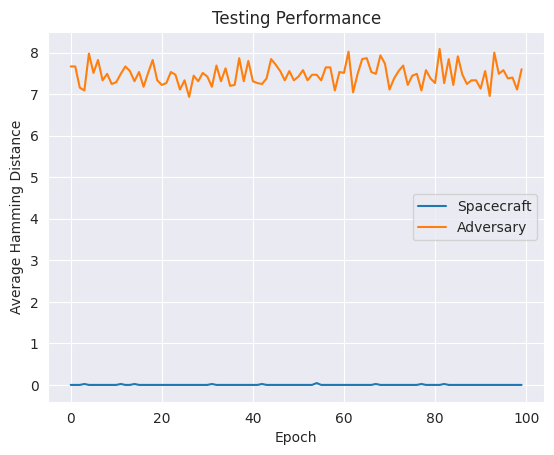

Total Spacecraft distance average: 0.0022222222222222222
Total Adversary distance average: 7.460222222222223


In [ ]:
#function accepts a matrix of binary and reformats the data back into text
def binary_to_text(binary):
    #binary=np.reshape(binary,(-1,))[:-pad_length]
    #reshaping into form of 8 bits
    binary=np.reshape(binary,(-1,8))
    bit_array=np.arange(7,-1,-1)
    bit_converter=np.power(2,bit_array)
    byte_list=np.dot(binary,bit_converter).tolist()
    text=''.join(list(map(chr,byte_list)))
    return text

def plot_test_results(spaceCraft_data,adversary_data):
    """
    Plot Lowest Decryption Errors achieved by Spacecraft & Adversory per epoch
    """
    sns.set_style("darkgrid")


    plt.plot(spaceCraft_data, label='Spacecraft')
    plt.plot(adversary_data, label='Adversary')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Average Hamming Distance')
    plt.title('Testing Performance')
    plt.show()


def testFunc(models,plain_text):

    binary_plain_text=text_to_binary_array(text)
    key = np.random.randint(0,2,binary_plain_text.shape)

    print(f'Plain text = {plain_text=}\n\n')
    print(f'Binary Plain text = \n{binary_plain_text}\n\n')
    print(f'Key = \n{key}\n\n')
    cipher_bin=models['groundstation']([binary_plain_text,key])
    print(f'Cipher Text Binary = \n{cipher_bin} \n\n')
    adversary_bin=np.round(models['adversary'](cipher_bin)).astype(np.int8)
    print(f'Adversary Binary = \n{adversary_bin}\n\n')
    spacecraft_bin=models['spacecraft']([cipher_bin,key])
    spacecraft_bin=np.round(spacecraft_bin).astype(np.int8)

    spacecraft_avg_dist=np.mean(np.linalg.norm(spacecraft_bin-binary_plain_text,axis=1,ord=1))
    adversary_average_dist=np.mean(np.linalg.norm(adversary_bin-binary_plain_text,axis=1,ord=1))
    print(f'Spacecraft Binary =\n{spacecraft_bin}\n\n')

    #convert adversary and spacecraft text
    spacecraft_text=binary_to_text(spacecraft_bin)
    adversary_text=binary_to_text(adversary_bin)
    print(f'Adversary text= {adversary_text}\n\n')
    print(f'Spacecraft text= {spacecraft_text}\n\n')
    print(f'Spacecraft average Hamming distance ={spacecraft_avg_dist}\n')
    print(f'Adversary average Hamming distance ={adversary_average_dist}')

    return spacecraft_avg_dist,adversary_average_dist


text="This is a test on the deep space neural network cryptography project for the 4NN3 course."
testFunc({'groundstation': GroundStation_model, 'spacecraft': Spacecraft_model, 'adversary': Adversary_model},
        text )
def trainLoop(models,iterations):
    averages=np.zeros((iterations,2))
    for step in range(iterations):
        sentence=gen.sentence()
        averages[step]=testFunc(models,sentence)

    plot_test_results(averages[:,0],averages[:,1])

    return averages[:,0],averages[:,1]


TEST_ITERATIONS=100
spaceCraft_averages,adversary_averages=trainLoop({'groundstation': GroundStation_model, 'spacecraft': Spacecraft_model, 'adversary': Adversary_model},TEST_ITERATIONS)
print(f"Total Spacecraft distance average: {np.mean(spaceCraft_averages)}\nTotal Adversary distance average: {np.mean(adversary_averages)}")

## **Benchmarking against AES-256**
This script benchmarks the performance of AES-256 encryption against a neural network-based cryptographic system. The run_benchmark function performs encryption (and optionally decryption) using the neural network models for the ground station and spacecraft. The encrypt_aes_256 function encrypts data using AES-256 with CBC mode and PKCS7 padding. Benchmark timings for both AES-256 and the neural network encryption are obtained using timeit.timeit over 10,000 iterations, with the results printed for comparison. This allows for an evaluation of the efficiency of the neural network approach against the established AES-256 standard in terms of processing time.

In [ ]:
def run_benchmark(models, message, key, decrypt=False):
    cipher_bin = models['groundstation']([message, key])
    if decrypt:
        decipher_bin = models['spacecraft']([cipher_bin, key])


def encrypt_aes_256(data, key):
    padder = padding.PKCS7(algorithms.AES.block_size).padder()
    padded_data = padder.update(data) + padder.finalize()
    iv = os.urandom(16)

    cipher = Cipher(algorithms.AES(key), modes.CBC(iv))
    encryptor = cipher.encryptor()
    ciphertext = encryptor.update(padded_data) + encryptor.finalize()

    return ciphertext


benchmark_bin = text_to_binary_array('This is a sample plaintext for benchmarking.')

aes_key = os.urandom(32)
aes_time = timeit.timeit(lambda: encrypt_aes_256(benchmark_bin, aes_key), number=10000)
print(f"AES-256 Encryption Benchmark: {aes_time} seconds for 10,000 iterations")

models = {
    'groundstation': GroundStation_model,
    'spacecraft': Spacecraft_model
}
nn_key = np.random.randint(0, 2, benchmark_bin.shape)

nn_time = timeit.timeit(lambda: run_benchmark(models, benchmark_bin, nn_key), number=10000)
print(f"NN Encryption Benchmark: {nn_time} seconds for 10,000 iterations")

AES-256 Encryption Benchmark: 0.5504710509994766 seconds for 10,000 iterations
NN Encryption Benchmark: 85.29309205699974 seconds for 10,000 iterations
